# Merging Data
This notebook explores, if the metrics increase, when the labels are reduced. Additionally all results of the others notebooks are integrated. Below is a outline for the content.

1. Installing missing Packages
2. Import Packages
3. Data
   3.1 Import Data
   3.2 Data Structure
4. Model: Base-Line-Model
   4.1 Data Processing
   4.2 Model Parameters
   4.3 Training
   4.4 Testing
5. Model: Merge "Celebration" & "Excitement"
   5.1 Data Processing
       5.1.1 Merging
       5.1.2 Processing
       5.1.3 Train- and Test-Split
   5.2 Model Parameters
   5.3 Training
   5.4 Testing
6. Model: Merge "Celebration" & "Excitement" and "Disappointment" & "Boring"
   6.1 Data Processing
       6.1.1 Merging
       6.1.2 Processing
       6.1.3 Train- and Test-Split
   6.2 Model Parameters
   6.3 Training
   6.4 Testing
7. Conclusion of Merging
8. Model: Merge "Celebration" & "Excitement" with Data Augmentation
   8.1 Data Augmentation: "Disappointment" with n_augments = 1
       8.1.1 Data Processing
       8.1.2 Model Parameters
       8.1.3 Training
       8.1.4 Testing
   8.2 Data Augmentation: "Disappointment" with n_augments = 2
       8.2.1 Data Processing
       8.2.2 Model Parameters
       8.2.3 Training
       8.2.4 Testing
9. Conclusion

## 1. Installing missing Packages

In [ ]:
%%capture
!pip install transformers datasets accelerate
!pip install librosa

## 2. Import Packages

In [2]:
import transformers
from transformers import AutoFeatureExtractor, ASTForAudioClassification, AutoModelForAudioClassification
from transformers import Trainer

from datasets import load_dataset, Dataset
from collections import Counter

import torch
import torch.nn as nn

import librosa

import random
import numpy as np
import json

from pprint import pprint

import sklearn.metrics as skm
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

## 3. Data

We talked already about the Data in notebook "XXX". This chapter just prints the most important informations for the later usage.

### 3.1 Import Data

In [3]:
path = 'Neuronale Netze/EA - groß - Gruppenarbeit/16k_data/meta.json'
arrays = np.load('/home/jovyan/workspace/Neuronale Netze/EA - groß - Gruppenarbeit/16k_data/training_25112024.npz')
meta = json.load(open('/home/jovyan/workspace/Neuronale Netze/EA - groß - Gruppenarbeit/16k_data/meta.json', 'r'))

### 3.2 Data Structure

In [4]:
print(arrays)

NpzFile '/home/jovyan/workspace/Neuronale Netze/EA - groß - Gruppenarbeit/16k_data/training_25112024.npz' with keys: X, y, groups


In [5]:
print(arrays['X'])

[[ 3.2830704e-04  9.9163875e-03  1.6845936e-02 ...  4.8440071e-03
   6.7358743e-04 -3.9298702e-03]
 [-8.2107643e-03 -9.7427005e-03 -5.7625356e-03 ...  5.6111747e-03
   7.0165722e-03  3.7530088e-03]
 [-6.0349256e-03 -1.7513758e-02 -2.4519343e-02 ...  2.4389978e-03
   1.4424410e-02  2.3104530e-02]
 ...
 [ 3.4458810e-01  3.3406031e-01  2.9483637e-01 ... -7.2613396e-03
   1.7828370e-02  5.2196458e-02]
 [ 9.2880733e-02  7.2587684e-02  9.3194686e-02 ...  9.9426378e-03
   1.3490677e-01  1.3978356e-01]
 [ 2.5695339e-02 -6.2102992e-02 -2.7688213e-02 ...  9.9716447e-03
  -9.2344247e-02 -1.7016892e-01]]


In [6]:
print(arrays['y'])

[4 4 4 4 4 4 4 4 4 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 2 2 0 4 4 4 4 0 0 0 0 0 0
 0 0 0 2 1 1 1 1 3 3 3 3 2 2 4 4 4 4 4 4 4 0 0 0 0 0 1 1 1 2 1 1 1 1 1 1 3
 3 3 3 3 3 3 3 3 3 3 1 1 1 4 4 4 4 4 4 4 2 4 4 4 4 4 1 1 1 1 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 2 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 3
 3 3 1 3 3 3 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3
 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0
 0 0 0 1 1 3 3 3 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 1 1 1 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 

In [7]:
print(arrays['groups'])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3

In [8]:
pprint(meta)

{'labelfile': 'project-6-at-2024-11-23-15-47-9e286610.json',
 'labels': {'Boring': 4,
            'Celebration': 3,
            'Chanting/Singing': 0,
            'Disappointment': 2,
            'Excitement': 1},
 'sample_rate': 16000,
 'snippet_sec': 1,
 'sources': ['HKvsBHUTAN001.wav',
             'HKvsBHUTAN002.wav',
             'HKvsBRUNEI.wav',
             '2023716VS.wav',
             '1ExcitementDisappointment.MP3.wav',
             '2ExcitementCelebration.MP3.wav',
             '3Boring.MP3.wav',
             'Boring_001.wav',
             'Celebration_001.MP3.wav',
             'Celebration_002.MP3.wav',
             'Combine.MP3.wav',
             'Disappointment_001.wav',
             'Disappointment_002.wav',
             'Excitement_001.MP3.wav',
             'HongKongvsSingaporeInternationalFriendlyMongkokStadium.wav',
             'test.MP3.wav']}


## 4. Model: Base-Line-Model

This is the model from the notebook "XXX" which will be the base line model for the conclusion to answer the question, if merging data improces the metrics of the model.

In [ ]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
device = 'cuda'

### 4.1 Data Processing

In [10]:
arrays

NpzFile '/home/jovyan/workspace/Neuronale Netze/EA - groß - Gruppenarbeit/16k_data/training_25112024.npz' with keys: X, y, groups

In [11]:
meta['labels']

{'Chanting/Singing': 0,
 'Excitement': 1,
 'Disappointment': 2,
 'Celebration': 3,
 'Boring': 4}

#### 4.1.1 Processing

In [12]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

preprocessed_audio = feature_extractor(
    arrays['X'],
    sampling_rate = meta['sample_rate'],
    return_tensors = "pt"
)

hf_dataset = Dataset.from_dict({
    "input_values": preprocessed_audio['input_values'],
    "label": arrays['y'],
})

In [13]:
hf_dataset

Dataset({
    features: ['input_values', 'label'],
    num_rows: 906
})

#### 4.1.2 Train- und Test-Split

In [14]:
gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=42)
gss.get_n_splits()

for i, (train_index, test_index) in enumerate(gss.split(**arrays)):
    print(f"Fold {i}:")
    print(f"  Train: source={set(arrays['groups'][train_index])}")
    print(f"  Test:  source={set(arrays['groups'][test_index])}")

Fold 0:
  Train: source={np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(1), np.int64(5), np.int64(14)}
Fold 1:
  Train: source={np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(2), np.int64(13), np.int64(6)}
Fold 2:
  Train: source={np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(1), np.int64(13), np.int64(5)}
Fold 3:
  Train: source={np.int64(1), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(2), np.

In [15]:
(train_index, test_index) = next(gss.split(**arrays))

In [16]:
train_ds = hf_dataset.select(train_index)
train_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 677
})

In [17]:
test_ds = hf_dataset.select(test_index)
test_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 229
})

### 4.2 Model Parameters

In [18]:
model2train = AutoModelForAudioClassification.from_pretrained(
    model_name,
    num_labels = len(meta['labels']),
    label2id = meta['labels'],
    id2label = {v:k for k,v in meta['labels'].items()},
    ignore_mismatched_sizes = True
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
batch_size = 8
args = transformers.TrainingArguments(
    f'{model_name.split("/")[-1]}-ft_stadium',

    learning_rate=1e-5,
    warmup_ratio=0.1,

    eval_strategy = "steps",
    eval_steps = 10,
    logging_steps=10,

    save_strategy = "epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    gradient_accumulation_steps=4,
    num_train_epochs=5,
    load_best_model_at_end=False,
    push_to_hub=False,
)

In [20]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(torch.long)  # Labels in int64 konvertieren
        outputs = model(**inputs)
        logits = outputs.logits.to(torch.float32)  # Logits in float32 konvertieren

        # Loss-function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)

        metrics = {
            'accuracy': skm.accuracy_score(labels, preds),
            'macro_f1': skm.f1_score(labels, preds, average='macro'),
            'weighted_f1': skm.f1_score(labels, preds, average='weighted')
        }

        return metrics

In [21]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(hf_dataset['label']),
    y = hf_dataset['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.4897, 1.8875, 3.0200, 2.1318, 0.6142], device='cuda:0')


In [22]:
trainer = CustomTrainer(
    model=model2train,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    processing_class = feature_extractor, #tokenizer=feature_extractor,
    class_weights=class_weights,
    compute_metrics=CustomTrainer.compute_metrics
)

### 4.3 Training

In [23]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
10,1.684600,1.477028,0.441048,0.312360,0.457456
20,1.241400,1.050055,0.733624,0.657671,0.748780
30,0.690300,0.787301,0.790393,0.670128,0.794165
40,0.515900,0.717811,0.772926,0.662416,0.790746
50,0.362300,0.636677,0.807860,0.659130,0.802443
60,0.333200,0.619444,0.816594,0.692930,0.819413
70,0.281500,0.610140,0.812227,0.704595,0.821796
80,0.206800,0.590386,0.816594,0.663572,0.803889
90,0.178200,0.603741,0.803493,0.660093,0.801881
100,0.160200,0.588373,0.807860,0.670452,0.805710


TrainOutput(global_step=105, training_loss=0.5461433677446275, metrics={'train_runtime': 444.4349, 'train_samples_per_second': 7.616, 'train_steps_per_second': 0.236, 'total_flos': 2.2043569543446528e+17, 'train_loss': 0.5461433677446275, 'epoch': 4.8})

In [24]:
training_logs  = trainer.state.log_history
len(training_logs)

21

In [26]:
loss_values = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]
steps = [log["step"] for log in training_logs if "loss" in log]

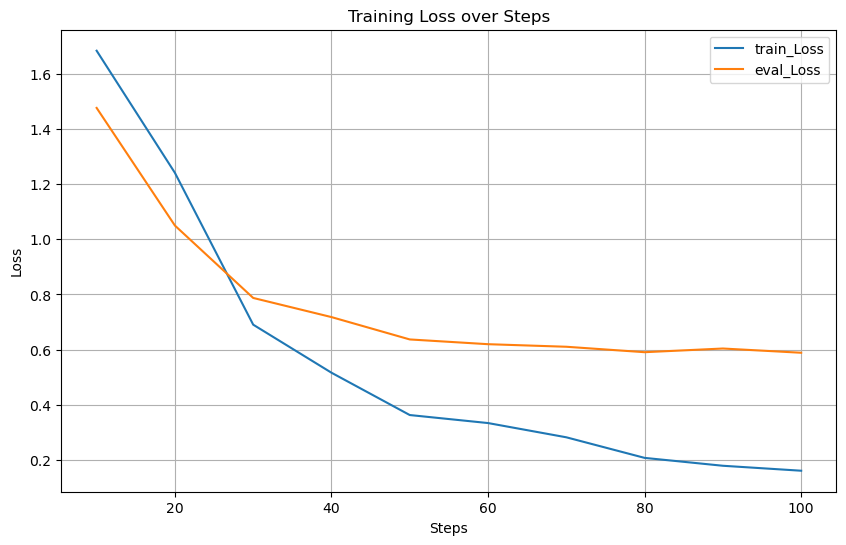

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(steps, loss_values, label="train_Loss")
plt.plot(steps, eval_loss, label="eval_Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.grid()
plt.show()

Based on the graph and the output of the trainer, the training process is completely exhausted after from 70 steps onwards. Afterward overfitting seems to take place, in wich the of the training data continues to decrease, but the loss of the evaluation data remains the same.

### 4.4 Testing

In [28]:
pred = trainer.predict(test_ds)

In [30]:
print(classification_report(pred.label_ids, pred.predictions.argmax(1)))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       100
           1       0.29      0.27      0.28        15
           2       0.53      0.50      0.51        20
           3       0.73      0.88      0.80        25
           4       0.80      0.88      0.84        69

    accuracy                           0.81       229
   macro avg       0.67      0.68      0.67       229
weighted avg       0.81      0.81      0.81       229



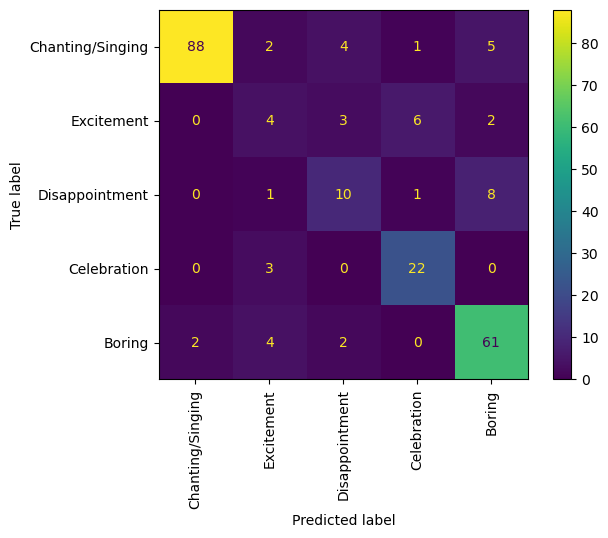

In [29]:
cmd = skm.ConfusionMatrixDisplay(
    skm.confusion_matrix(pred.label_ids, pred.predictions.argmax(1)),
    display_labels = meta.get('labels').keys()
)
cmd.plot(xticks_rotation="vertical")

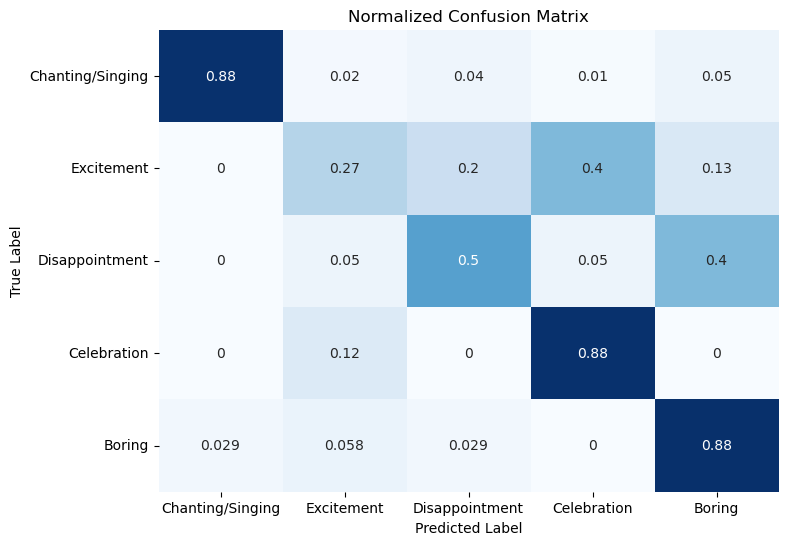

In [34]:
id2label = {v:k for k,v in meta['labels'].items()}
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(1), normalize='true')


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

The classification report shows, that the base line has an accuracy of about 81 %. Additionally, we can look at the independent labels in the two confusion matrix. They show, that Chanting/Singing, Celebration and the label Boring have good results on the true positives. All three above 80 %. Disappointment has a true positiv-rate about 50 % and Excitement is low at about 1/4. Both labels show, that a lot of them are categorized in mostly one other label. For Excitement, it is Celebration, which makes sense, because their very similiar expressions of joy and distinguish in  details and gesture. For Disappointment, it is mostly (falsely) recognized as Boring, because both of them are rather calm reactions.\

Based on this, the following models aim to decrease the number of labels with merging them together. With the merging, the data can still be used, but the model complexity decreases, the big question is "Is this still in alignment with the contract?" and has to be discussed with the contractor.


## 5. Model: Merge "Celebration" & "Excitement"

This is chapter trys to enhance the base line model with merging the labels "Celebration" and "Excitement" into one label.

In [ ]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
device = 'cuda'

### 5.1 Data Processing

In [64]:
arrays['y']

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0,
       0, 0, 2, 2, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 3, 3, 3, 3, 2, 2, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 4,
       4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 0, 0, 0, 0, 0, 0, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### 5.1.1 Merging

In [79]:
meta_labels = {
     'Chanting/Singing': 0,
     'Excitement/Celebration': 1,
     'Disappointment': 2,
     'Boring': 3
}

{'Chanting/Singing': 0,
 'Excitement/Celebration': 1,
 'Disappointment': 2,
 'Boring': 3}

In [78]:
nparray2 = np.where(arrays['y']==3, 1, arrays['y'])
nparray2 = np.where(nparray2==4, 3, nparray2)
nparray2

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 2, 2, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### 5.1.2 Processing

In [80]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

preprocessed_audio = feature_extractor(
    arrays['X'],
    sampling_rate = meta['sample_rate'],
    return_tensors = "pt"
)

hf_dataset = Dataset.from_dict({
    "input_values": preprocessed_audio['input_values'],
    "label": nparray2,
})

In [81]:
hf_dataset

Dataset({
    features: ['input_values', 'label'],
    num_rows: 906
})

#### 5.1.3 Train- and Test-Split

In [82]:
gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=42)
gss.get_n_splits()

for i, (train_index, test_index) in enumerate(gss.split(**arrays)):
    print(f"Fold {i}:")
    print(f"  Train: source={set(arrays['groups'][train_index])}")
    print(f"  Test:  source={set(arrays['groups'][test_index])}")

Fold 0:
  Train: source={np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(1), np.int64(5), np.int64(14)}
Fold 1:
  Train: source={np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(2), np.int64(13), np.int64(6)}
Fold 2:
  Train: source={np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(1), np.int64(13), np.int64(5)}
Fold 3:
  Train: source={np.int64(1), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(2), np.

In [83]:
(train_index, test_index) = next(gss.split(**arrays))

In [92]:
train_ds = hf_dataset.select(train_index)
train_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 677
})

In [93]:
test_ds = hf_dataset.select(test_index)
test_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 229
})

### 5.2 Model Parameters

In [94]:
model2train = AutoModelForAudioClassification.from_pretrained(
    model_name,
    num_labels = len(meta_labels),
    label2id = meta_labels,
    id2label = {v:k for k,v in meta_labels.items()},
    ignore_mismatched_sizes = True
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [95]:
batch_size = 8
args = transformers.TrainingArguments(
    f'{model_name.split("/")[-1]}-ft_stadium',

    learning_rate=1e-5,
    warmup_ratio=0.1,

    eval_strategy = "steps",
    eval_steps = 10,
    logging_steps=10,

    save_strategy = "epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    gradient_accumulation_steps=4,
    num_train_epochs=5,
    load_best_model_at_end=False,
    push_to_hub=False,
)

In [96]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(torch.long)  # Labels in int64 konvertieren
        outputs = model(**inputs)
        logits = outputs.logits.to(torch.float32)  # Logits in float32 konvertieren

        # Loss-function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)

        metrics = {
            'accuracy': skm.accuracy_score(labels, preds),
            'macro_f1': skm.f1_score(labels, preds, average='macro'),
            'weighted_f1': skm.f1_score(labels, preds, average='weighted')
        }

        return metrics

In [97]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique( hf_dataset['label']),
    y = hf_dataset['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.6122, 1.2514, 3.7750, 0.7678], device='cuda:0')


In [98]:
trainer = CustomTrainer(
    model=model2train,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    processing_class = feature_extractor, #tokenizer=feature_extractor,
    class_weights=class_weights,
    compute_metrics=CustomTrainer.compute_metrics
)

### 5.3 Training

In [99]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
10,1.466100,1.300210,0.427948,0.288414,0.396168
20,1.050200,0.932918,0.655022,0.610460,0.655565
30,0.497700,0.701421,0.799127,0.694899,0.783973
40,0.374700,0.613318,0.807860,0.761411,0.814469
50,0.204400,0.561840,0.842795,0.788974,0.838458
60,0.219500,0.504076,0.825328,0.769686,0.827099
70,0.235200,0.488751,0.829694,0.777492,0.830247
80,0.125700,0.496404,0.860262,0.797146,0.854705
90,0.109200,0.504642,0.842795,0.801542,0.840407
100,0.114300,0.472276,0.855895,0.812778,0.853359


TrainOutput(global_step=105, training_loss=0.4223666517507462, metrics={'train_runtime': 451.3047, 'train_samples_per_second': 7.5, 'train_steps_per_second': 0.233, 'total_flos': 2.2043372873475686e+17, 'train_loss': 0.4223666517507462, 'epoch': 4.8})

In [100]:
training_logs  = trainer.state.log_history
training_logs

[{'loss': 1.4661,
  'grad_norm': 10.76355266571045,
  'learning_rate': 9.090909090909091e-06,
  'epoch': 0.47058823529411764,
  'step': 10},
 {'eval_loss': 1.3002099990844727,
  'eval_accuracy': 0.4279475982532751,
  'eval_macro_f1': 0.28841422804561456,
  'eval_weighted_f1': 0.39616833045300875,
  'eval_runtime': 14.3638,
  'eval_samples_per_second': 15.943,
  'eval_steps_per_second': 2.019,
  'epoch': 0.47058823529411764,
  'step': 10},
 {'loss': 1.0502,
  'grad_norm': 9.615665435791016,
  'learning_rate': 9.042553191489362e-06,
  'epoch': 0.9411764705882353,
  'step': 20},
 {'eval_loss': 0.9329177141189575,
  'eval_accuracy': 0.6550218340611353,
  'eval_macro_f1': 0.6104604900130062,
  'eval_weighted_f1': 0.6555646868502293,
  'eval_runtime': 14.6616,
  'eval_samples_per_second': 15.619,
  'eval_steps_per_second': 1.978,
  'epoch': 0.9411764705882353,
  'step': 20},
 {'loss': 0.4977,
  'grad_norm': 14.356802940368652,
  'learning_rate': 7.97872340425532e-06,
  'epoch': 1.37647058823

In [101]:
loss_values = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]
steps = [log["step"] for log in training_logs if "loss" in log]

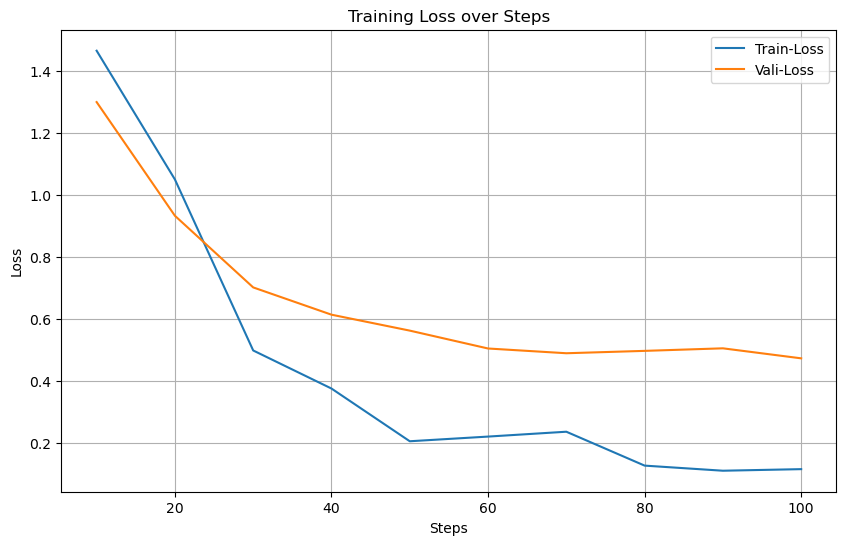

In [103]:
plt.figure(figsize=(10, 6))
plt.plot(steps, loss_values, label="Train-Loss")
plt.plot(steps, eval_loss, label="Vali-Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.grid()
plt.show()

Based on the graph and the output of the trainer, the training process is completely exhausted after from 70 steps onwards. Afterward overfitting seems to take place, in wich the of the training data continues to decrease, but the loss of the evaluation data remains the same.

### 5.4 Testing

In [104]:
pred = trainer.predict(test_ds)

In [106]:
print(classification_report(pred.label_ids, pred.predictions.argmax(1)))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       100
           1       0.84      0.95      0.89        40
           2       0.73      0.55      0.63        20
           3       0.81      0.87      0.84        69

    accuracy                           0.86       229
   macro avg       0.83      0.81      0.81       229
weighted avg       0.86      0.86      0.85       229



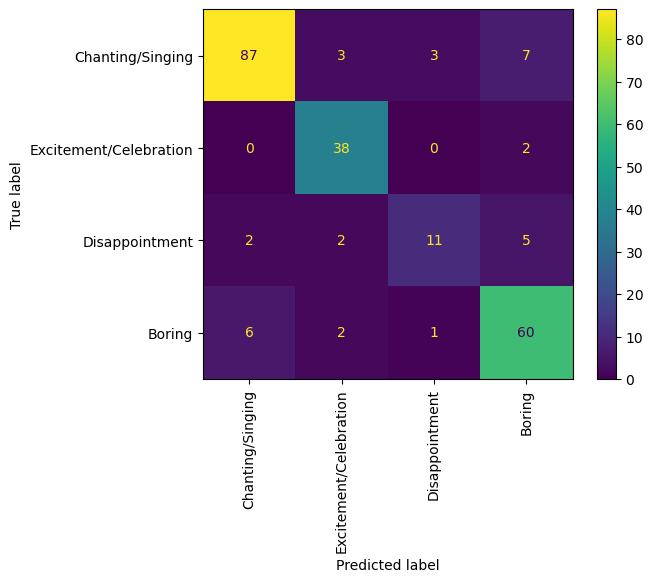

In [105]:
cmd = skm.ConfusionMatrixDisplay(
    skm.confusion_matrix(pred.label_ids, pred.predictions.argmax(1)),
    display_labels = meta_labels.keys()
)
cmd.plot(xticks_rotation="vertical")

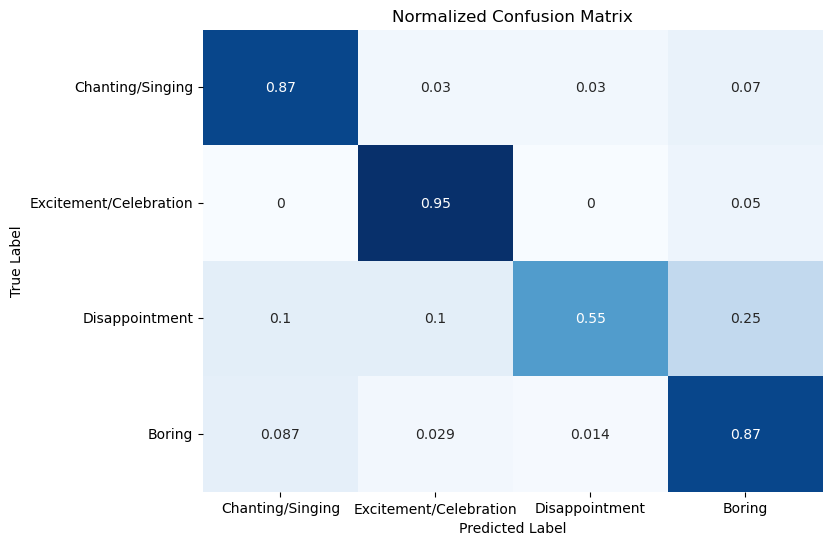

In [110]:
id2label = {v:k for k,v in meta_labels.items()}
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(1), normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

In comparison with the base line model, the accuracy increased from 81 % to 86 %. "Chanting/Singing" and "Boring" decreased a little bit, but boring could increase by a little and the merged labels "Celebration/Excitement" increased greatly (if one can say increasing).Thus the merging was successfully, if as said before, one accept the loosing complexity. If we look more how the incorrectly assigned datapoints are distributed, a lot of "Disappointment" are assigned to "Boring" like in the base line model. The next model investigate if the additional merging of these two labels also increase the accuracy.

## 6. Model: Merge "Celebration" & "Excitement" and "Disappointment" & "Boring"

In [ ]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
device = 'cuda'

### 6.1 Data Processing

#### 6.1.1 Merging

In [60]:
meta_labels = {
     'Chanting/Singing': 0,
     'Excitement/Celebration': 1,
     'Disappointment/Boring': 2,
}

{'Chanting/Singing': 0, 'Excitement': 1, 'Disappointment/Boring': 2}

In [59]:
nparray2 = np.where(arrays['y']==3, 1, arrays['y'])
nparray2 = np.where(nparray2==4, 2, nparray2)
nparray2

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### 6.1.2 Processing

In [61]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

preprocessed_audio = feature_extractor(
    arrays['X'],
    sampling_rate = meta['sample_rate'],
    return_tensors = "pt"
)

hf_dataset = Dataset.from_dict({
    "input_values": preprocessed_audio['input_values'],
    "label": nparray2,
})

In [62]:
hf_dataset

Dataset({
    features: ['input_values', 'label'],
    num_rows: 906
})

In [63]:
print(hf_dataset['label'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 

#### 6.1.3 Train- and Test-Split

In [133]:
gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=42)
gss.get_n_splits()

for i, (train_index, test_index) in enumerate(gss.split(**arrays)):
    print(f"Fold {i}:")
    print(f"  Train: source={set(arrays['groups'][train_index])}")
    print(f"  Test:  source={set(arrays['groups'][test_index])}")

Fold 0:
  Train: source={np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(1), np.int64(5), np.int64(14)}
Fold 1:
  Train: source={np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(2), np.int64(13), np.int64(6)}
Fold 2:
  Train: source={np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(1), np.int64(13), np.int64(5)}
Fold 3:
  Train: source={np.int64(1), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(2), np.

In [134]:
(train_index, test_index) = next(gss.split(**arrays))

In [135]:
train_ds = hf_dataset.select(train_index)
train_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 677
})

In [136]:
test_ds = hf_dataset.select(test_index)
test_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 229
})

### 6.2 Model Parameters

In [137]:
model2train = AutoModelForAudioClassification.from_pretrained(
    model_name,
    num_labels = len(meta_labels),
    label2id = meta_labels,
    id2label = {v:k for k,v in meta_labels.items()},
    ignore_mismatched_sizes = True
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [138]:
batch_size = 8
args = transformers.TrainingArguments(
    f'{model_name.split("/")[-1]}-ft_stadium',

    learning_rate=1e-5,
    warmup_ratio=0.1,


    eval_strategy = "steps",
    eval_steps = 10,
    logging_steps=10,

    save_strategy = "epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    gradient_accumulation_steps=4,
    num_train_epochs=5,
    load_best_model_at_end=False,
    push_to_hub=False,
)

In [139]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(torch.long)  # Labels in int64 konvertieren
        outputs = model(**inputs)
        logits = outputs.logits.to(torch.float32)  # Logits in float32 konvertieren

        # Loss-function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)

        metrics = {
            'accuracy': skm.accuracy_score(labels, preds),
            'macro_f1': skm.f1_score(labels, preds, average='macro'),
            'weighted_f1': skm.f1_score(labels, preds, average='weighted')
        }

        return metrics

In [140]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique( hf_dataset['label']),
    y = hf_dataset['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.8162, 1.6685, 0.8507], device='cuda:0')


In [141]:
trainer = CustomTrainer(
    model=model2train,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    processing_class = feature_extractor, #tokenizer=feature_extractor,
    class_weights=class_weights,
    compute_metrics=CustomTrainer.compute_metrics
)

### 6.3 Training

In [142]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
10,1.169800,0.796186,0.703057,0.551250,0.650358
20,0.654700,0.561745,0.755459,0.735612,0.773601
30,0.314400,0.326809,0.895197,0.879857,0.899377
40,0.267300,0.294830,0.917031,0.909319,0.917987
50,0.190900,0.247135,0.921397,0.919729,0.921899
60,0.155100,0.264643,0.903930,0.892299,0.906121
70,0.131300,0.264777,0.899563,0.885608,0.902504
80,0.102300,0.231381,0.921397,0.921727,0.922165
90,0.069100,0.232567,0.925764,0.918033,0.926575
100,0.075400,0.246378,0.917031,0.909241,0.917965


TrainOutput(global_step=105, training_loss=0.3001908317917869, metrics={'train_runtime': 452.0136, 'train_samples_per_second': 7.489, 'train_steps_per_second': 0.232, 'total_flos': 2.2043176203504845e+17, 'train_loss': 0.3001908317917869, 'epoch': 4.8})

In [143]:
training_logs  = trainer.state.log_history
training_logs

[{'loss': 1.1698,
  'grad_norm': 11.293336868286133,
  'learning_rate': 9.090909090909091e-06,
  'epoch': 0.47058823529411764,
  'step': 10},
 {'eval_loss': 0.7961860299110413,
  'eval_accuracy': 0.7030567685589519,
  'eval_macro_f1': 0.5512501664166222,
  'eval_weighted_f1': 0.6503578645614457,
  'eval_runtime': 14.949,
  'eval_samples_per_second': 15.319,
  'eval_steps_per_second': 1.94,
  'epoch': 0.47058823529411764,
  'step': 10},
 {'loss': 0.6547,
  'grad_norm': 8.857486724853516,
  'learning_rate': 9.042553191489362e-06,
  'epoch': 0.9411764705882353,
  'step': 20},
 {'eval_loss': 0.5617448687553406,
  'eval_accuracy': 0.7554585152838428,
  'eval_macro_f1': 0.7356119204904475,
  'eval_weighted_f1': 0.7736010979374058,
  'eval_runtime': 14.5669,
  'eval_samples_per_second': 15.721,
  'eval_steps_per_second': 1.991,
  'epoch': 0.9411764705882353,
  'step': 20},
 {'loss': 0.3144,
  'grad_norm': 4.308926105499268,
  'learning_rate': 7.97872340425532e-06,
  'epoch': 1.376470588235294

In [144]:
loss_values = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]
steps = [log["step"] for log in training_logs if "loss" in log]

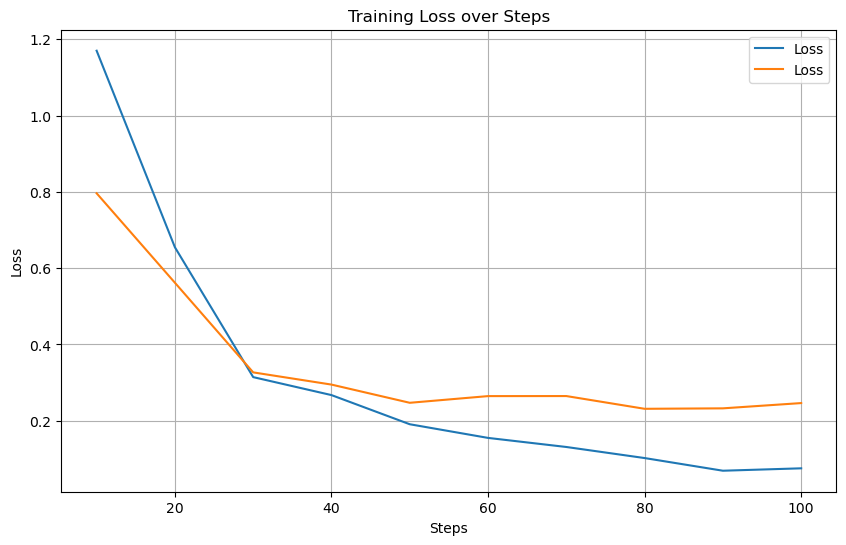

In [145]:
plt.figure(figsize=(10, 6))
plt.plot(steps, loss_values, label="Train-Loss")
plt.plot(steps, eval_loss, label="Vali-Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.grid()
plt.show()


Based on the graph and the output of the trainer, the training process is completely exhausted after from 50 steps onwards. Afterward overfitting seems to take place, in wich the of the training data continues to decrease slightly, but the loss of the evaluation data remains the same.

### 6.4 Testing

In [146]:
pred = trainer.predict(test_ds)

In [148]:
print(skm.classification_report(pred.label_ids, pred.predictions.argmax(1)))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93       100
           1       0.81      0.95      0.87        40
           2       0.91      0.93      0.92        89

    accuracy                           0.92       229
   macro avg       0.90      0.92      0.91       229
weighted avg       0.92      0.92      0.92       229



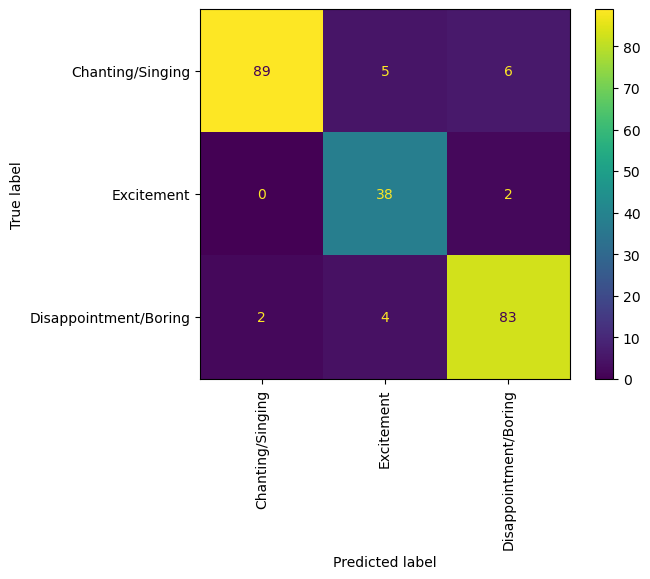

In [147]:
cmd = skm.ConfusionMatrixDisplay(
    skm.confusion_matrix(pred.label_ids, pred.predictions.argmax(1)),
    display_labels = meta_labels.keys()
)
cmd.plot(xticks_rotation="vertical")

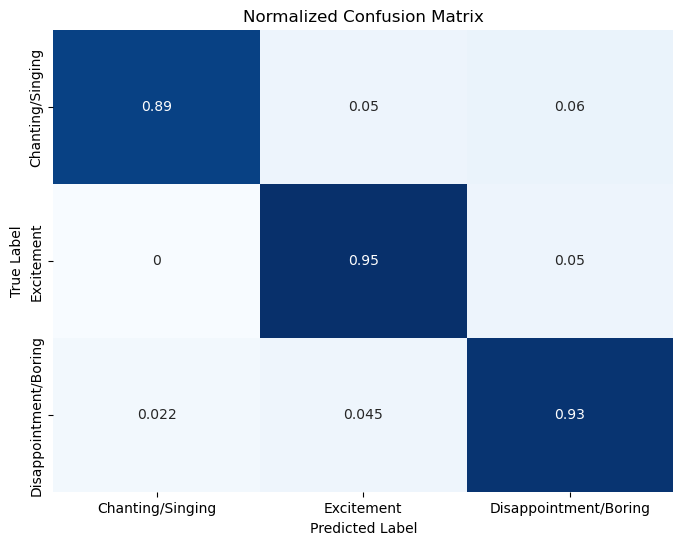

In [152]:
id2label = {v:k for k,v in meta_labels.items()}
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(1), normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

As before, the accuracy increases again by removing additional complexity. The accuracy increases from 86 % to 92 %. "Chanting/Singing" increased and "Excitement/Celebration" is about the same as in the model before. The new merged label has an accuracy of 93 %.\
All together the model has a relatively high accrucy compared to before, on the other hand it also forfeits a lot of complexity in the output. It is discussible, if both merging are meaningful, and it depends the most on the use case of this model. The compromise is, to just merge "Excitement" and "Celebration" to increase the accuracy and look for other possibilities. One is, as in notebook XX described, the augmentation of the labels with fewer data points. This will be explored in the following models.

## 7. Conclusion of Merging

- unbalanced data

**Base-Line-Model**
- Accuracy 82 %
- "Excitement" and "Disappointment" bad predicted
- "Chanting/Singing", "Celebration", "Boring" good predicted
- most of "Excitements" as "Celebration" (40 %)
- most of "Disappointment" as Boring (40 %)

**Model: Merge "Celebration" & "Excitement"**
- Accuracy 86 %
- "Excitement/Celebration" very good
- "Chanting/Singing" and "Boring" good
- "Disappointment" medium
- quarter of "Disappointment" as "Boring"
- loss of one label-complexity

**Model: Merge "Celebration" & "Excitement" and "Disappointment" & "Boring"**
- Accuracy 92 %
- "Excitement/Celebration", "Disappointment/Boring" very good
- "Chanting/Singing" good
- loss of two label-complexity

**Due to the high loss of complexity, the first model, which combines "Excitement" and "Celebration", is used to further investigate the influence of data augmentation.**

## 8. Model: Merge "Celebration" & "Excitement" with Data Augmentation

As discussed in the previous chapter, it will be further explored, if data augmentation does improve the model in terms of accuracy.

### 8.1 Data Augmentation: "Disappointment" with n_augments = 1

The first label, which will be augmented is the "Disappointment" label, resulting in doubled data points for "Disappointment, which will be seen later on. For more information look into the notebook "XXX"

In [ ]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
device = 'cuda'

#### 8.1.1 Data Processing

##### Merge "Celebration" & "Excitement"

In [12]:
meta_labels = {
     'Chanting/Singing': 0,
     'Excitement/Celebration': 1,
     'Disappointment': 2,
     'Boring': 3
}

{'Chanting/Singing': 0,
 'Excitement/Celebration': 1,
 'Disappointment': 2,
 'Boring': 3}

In [11]:
nparray2 = np.where(arrays['y']==3, 1, arrays['y'])
nparray2 = np.where(nparray2==4, 3, nparray2)
nparray2

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 2, 2, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [10]:
arrays['y']

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0,
       0, 0, 2, 2, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 3, 3, 3, 3, 2, 2, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 4,
       4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 0, 0, 0, 0, 0, 0, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

/tmp/ipykernel_61/1762133594.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(meta_labels.keys())


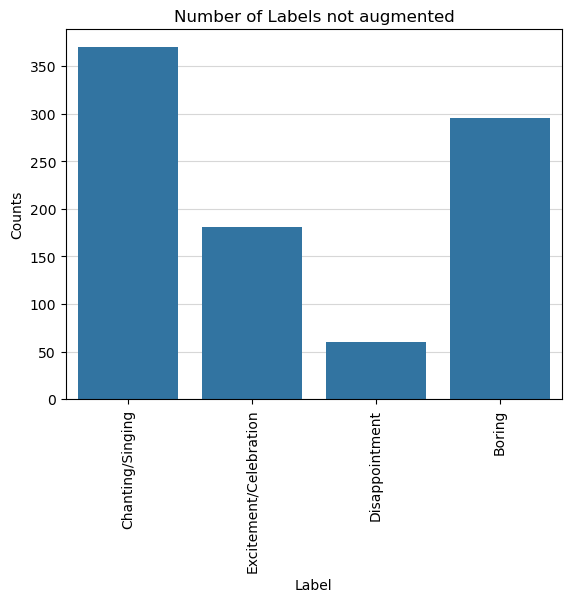

In [25]:
ax = sns.barplot(Counter(nparray2))
ax.set(xlabel='Label', ylabel='Counts')
ax.set_xticklabels(meta_labels.keys())
ax.tick_params(axis='x', labelrotation=90)
ax.set_axisbelow(True)
plt.grid(axis = 'y',alpha=0.5)
plt.title('Number of Labels not augmented')
plt.show()

##### Augmentation

In [27]:
def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio)) * noise_factor
    augmented_audio = audio + noise
    return np.clip(augmented_audio, -1.0, 1.0)  # Clips the audio between -1 and 1

def pitch_shift(audio, sr, shift=2):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=shift)

def time_stretch(audio, rate=1.1):
    return librosa.effects.time_stretch(audio, rate=rate)

# Beispiel eines Augmentierungsprozesses
def augment_audio(audio, sr):
    augmentation_type = random.choice(['noise', 'pitch', 'stretch'])

    if augmentation_type == 'noise':
        return add_noise(audio)
    elif augmentation_type == 'pitch':
        return pitch_shift(audio, sr)
    elif augmentation_type == 'stretch':
        return time_stretch(audio)

    return audio

In [28]:
def process_and_augment_dataset(arrays_X, arrays_y, arrays_groups, meta, feature_extractor, labels_to_augment, n_augments=5):
    augmented_audio_data = []
    augmented_labels = []
    augmented_groups = []

    sr = meta['sample_rate']

    for i, audio in enumerate(arrays_X):
        label = arrays_y[i]
        group = arrays_groups[i]

        # Originale Daten hinzufügen
        preprocessed_audio = feature_extractor(
            audio,
            sampling_rate=sr,
            return_tensors="pt"
        )
        augmented_audio_data.append(preprocessed_audio['input_values'])
        augmented_labels.append(label)  # Originales Label
        augmented_groups.append(group)

        # Augmentierung nur für Labels 1 und 2
        if label in labels_to_augment:
            for _ in range(n_augments):
                # Augmentierung auf rohen Audiodaten anwenden
                augmented_audio = augment_audio(audio, sr)

                # Feature-Extraktion nach der Augmentierung
                preprocessed_audio = feature_extractor(
                    augmented_audio,
                    sampling_rate=sr,
                    return_tensors="pt"
                )

                augmented_audio_data.append(preprocessed_audio['input_values'])
                augmented_labels.append(label)  # Augmentiertes Label
                augmented_groups.append(group)  # Ursprung der Daten

    # Alle augmentierten Eingabewerte kombinieren
    input_values = torch.cat(augmented_audio_data, dim=0)

    hf_dataset = Dataset.from_dict({
        "input_values": input_values.numpy(),  # In NumPy-Array umwandeln
        "label": np.array(augmented_labels)  # Labels als NumPy-Array
    })

    augmented_groups = np.array(augmented_groups) # groups als NumPy-Array

    return hf_dataset, augmented_groups

In [29]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

hf_dataset, augmented_groups = process_and_augment_dataset(
    arrays_X= arrays['X'],
    arrays_y= nparray2,
    arrays_groups= arrays['groups'],
    meta= meta,
    feature_extractor= feature_extractor,
    labels_to_augment=[2],
    n_augments=1 # bei <1 entstehen eventuell Duplikate
)

In [30]:
hf_dataset

Dataset({
    features: ['input_values', 'label'],
    num_rows: 966
})

In [31]:
augmented_groups

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3

In [32]:
Counter(hf_dataset['label'])

Counter({0: 370, 3: 295, 1: 181, 2: 120})

/tmp/ipykernel_61/1318691458.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(meta_labels.keys())


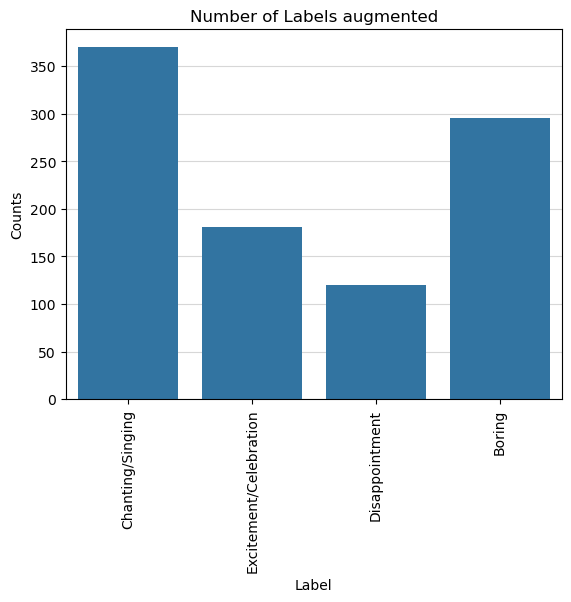

In [35]:
ax = sns.barplot(Counter(hf_dataset['label']))
ax.set(xlabel='Label', ylabel='Counts')
ax.set_xticklabels(meta_labels.keys())
ax.tick_params(axis='x', labelrotation=90)
ax.set_axisbelow(True)
plt.grid(axis = 'y',alpha=0.5)
plt.title('Number of Labels augmented')
plt.show()

As we can see in both diagramms, the number of data points for "Disappointment" are doubled.

##### Train- and Test-Split

In [92]:
gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=42)
gss.get_n_splits()

for i, (train_index, test_index) in enumerate(gss.split(X=hf_dataset["input_values"], y=hf_dataset["label"], groups=augmented_groups)):
    print(f"Fold {i}:")
    print(f"  Train: source={set(augmented_groups[train_index])}")
    print(f"  Test:  source={set(augmented_groups[test_index])}")

Fold 0:
  Train: source={np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(1), np.int64(5), np.int64(14)}
Fold 1:
  Train: source={np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(2), np.int64(13), np.int64(6)}
Fold 2:
  Train: source={np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(1), np.int64(13), np.int64(5)}
Fold 3:
  Train: source={np.int64(1), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(2), np.

In [93]:
# select one train test split
(train_index, test_index) = next(gss.split(X=hf_dataset["input_values"], y=hf_dataset["label"], groups=augmented_groups))

In [94]:
train_ds = hf_dataset.select(train_index)
train_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 717
})

In [95]:
test_ds = hf_dataset.select(test_index)
test_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 249
})

#### 8.1.2 Model Parameters

In [126]:
model2train = AutoModelForAudioClassification.from_pretrained(
    model_name,
    num_labels = len(meta_labels),
    label2id = meta_labels,
    id2label = {v:k for k,v in meta_labels.items()},
    ignore_mismatched_sizes = True
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [127]:
batch_size = 8
args = transformers.TrainingArguments(
    f'{model_name.split("/")[-1]}-ft_stadium',

    learning_rate=1e-5,
    warmup_ratio=0.1,


    eval_strategy = "steps",
    eval_steps = 10,
    logging_steps=10,

    save_strategy = "epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    gradient_accumulation_steps=4,
    num_train_epochs=5,
    load_best_model_at_end=False,
    push_to_hub=False,
)

In [128]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(torch.long)  # Labels in int64 konvertieren
        outputs = model(**inputs)
        logits = outputs.logits.to(torch.float32)  # Logits in float32 konvertieren

        # Loss-function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)

        metrics = {
            'accuracy': skm.accuracy_score(labels, preds),
            'macro_f1': skm.f1_score(labels, preds, average='macro'),
            'weighted_f1': skm.f1_score(labels, preds, average='weighted')
        }

        return metrics

In [129]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(hf_dataset['label']),
    y = hf_dataset['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.6527, 1.3343, 2.0125, 0.8186], device='cuda:0')


In [130]:
trainer = CustomTrainer(
    model=model2train,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    processing_class = feature_extractor, #tokenizer=feature_extractor,
    class_weights=class_weights,
    compute_metrics=CustomTrainer.compute_metrics
)

#### 8.1.3 Training


In [131]:
trainer.train() # 5 Epochs

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
10,1.508400,1.337137,0.269076,0.245375,0.256134
20,0.839100,0.766659,0.746988,0.704606,0.744728
30,0.426400,0.588628,0.799197,0.776822,0.813947
40,0.274600,0.454910,0.875502,0.844784,0.872495
50,0.222200,0.444083,0.883534,0.863008,0.885599
60,0.185600,0.429124,0.867470,0.858901,0.870909
70,0.117000,0.368306,0.903614,0.887343,0.903630
80,0.063500,0.379587,0.899598,0.883963,0.900027
90,0.077100,0.397581,0.871486,0.850249,0.872919
100,0.048500,0.373459,0.891566,0.877219,0.892498


TrainOutput(global_step=110, training_loss=0.34570471996610813, metrics={'train_runtime': 520.3518, 'train_samples_per_second': 6.89, 'train_steps_per_second': 0.211, 'total_flos': 2.4076894356268646e+17, 'train_loss': 0.34570471996610813, 'epoch': 4.977777777777778})

In [132]:
training_logs  = trainer.state.log_history
len(training_logs)

23

In [134]:
loss_values = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]
steps = [log["step"] for log in training_logs if "loss" in log]

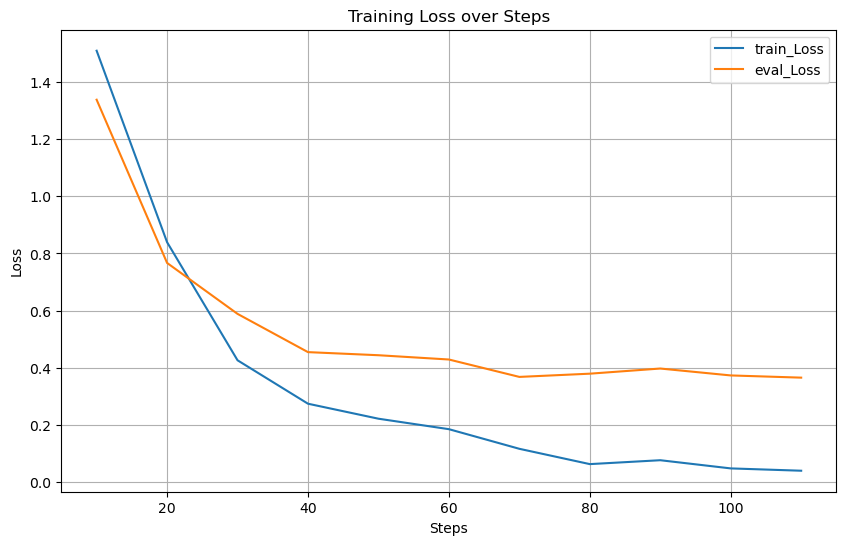

In [135]:
plt.figure(figsize=(10, 6))
plt.plot(steps, loss_values, label="train_Loss")
plt.plot(steps, eval_loss, label="eval_Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.grid()
plt.show()

The graph shows that the model is fully trained from around 70 steps onwards and then starts to “overfit” as the training loss is increasing and the validation loss doesn't change much.

#### 8.1.4 Testing

In [136]:
pred = trainer.predict(test_ds)

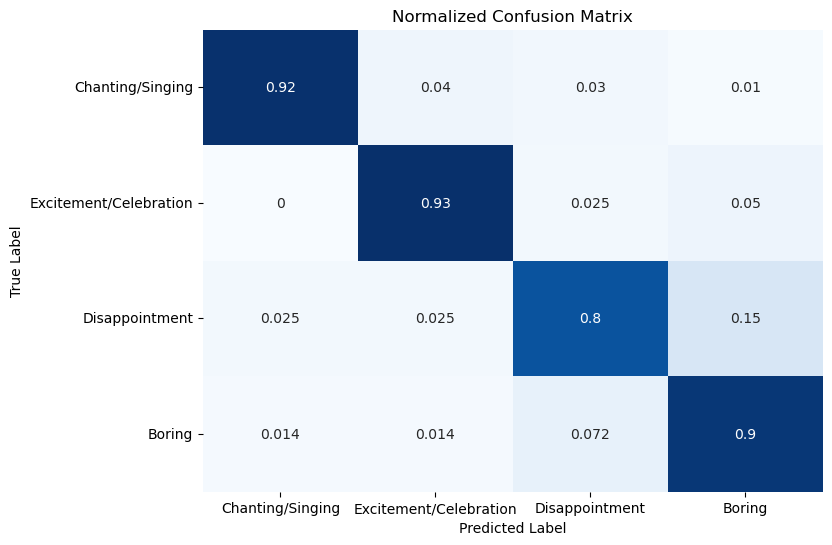

In [142]:
id2label = {v:k for k,v in meta_labels.items()}
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(1), normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

In the normalized confusion matrix it can be seen that the labels are recognized better. The accuracy of around 90% speaks for this. Without the augmentation of "disappointment" the accuracy was around 86 % (Model of chapter 5). Looking further at the matrix, it can be seen that the largest discrepancies arise between “Disappointment” and “Boring”, where 15% of the data points from “Disappointment” are incorrectly recognized as “Boring”. \
Another model is being investigated, which triples the data points "Disappointment" in the augmentation to investigate whether this makes the model better at recognizing the differences between "Disappointment" and "Boring".

### 8.2 Data Augmentation: "Disappointment" with n_augments = 2

Following the chapter 8.1, the data point will be increasing threefold by data augmentation. With this the difference in unbalanced data is further decreased.

In [ ]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
device = 'cuda'

#### 8.2.1 Data Processing

##### Merge "Celebration" & "Excitement"

In [41]:
meta_labels = {
     'Chanting/Singing': 0,
     'Excitement/Celebration': 1,
     'Disappointment': 2,
     'Boring': 3
}

{'Chanting/Singing': 0,
 'Excitement/Celebration': 1,
 'Disappointment': 2,
 'Boring': 3}

In [40]:
nparray2 = np.where(arrays['y']==3, 1, arrays['y'])
nparray2 = np.where(nparray2==4, 3, nparray2)
nparray2

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 2, 2, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [39]:
arrays['y']

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0,
       0, 0, 2, 2, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 3, 3, 3, 3, 2, 2, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 4,
       4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 0, 0, 0, 0, 0, 0, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

/tmp/ipykernel_61/1762133594.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(meta_labels.keys())


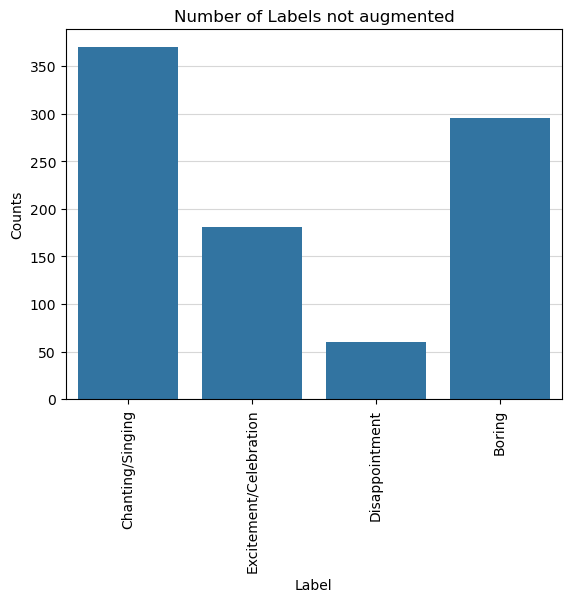

In [42]:
ax = sns.barplot(Counter(nparray2))
ax.set(xlabel='Label', ylabel='Counts')
ax.set_xticklabels(meta_labels.keys())
ax.tick_params(axis='x', labelrotation=90)
ax.set_axisbelow(True)
plt.grid(axis = 'y',alpha=0.5)
plt.title('Number of Labels not augmented')
plt.show()

##### Augmentation

In [43]:
def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio)) * noise_factor
    augmented_audio = audio + noise
    return np.clip(augmented_audio, -1.0, 1.0)  # Clips the audio between -1 and 1

def pitch_shift(audio, sr, shift=2):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=shift)

def time_stretch(audio, rate=1.1):
    return librosa.effects.time_stretch(audio, rate=rate)

# Beispiel eines Augmentierungsprozesses
def augment_audio(audio, sr):
    augmentation_type = random.choice(['noise', 'pitch', 'stretch'])

    if augmentation_type == 'noise':
        return add_noise(audio)
    elif augmentation_type == 'pitch':
        return pitch_shift(audio, sr)
    elif augmentation_type == 'stretch':
        return time_stretch(audio)

    return audio

In [44]:
def process_and_augment_dataset(arrays_X, arrays_y, arrays_groups, meta, feature_extractor, labels_to_augment, n_augments=5):
    augmented_audio_data = []
    augmented_labels = []
    augmented_groups = []

    sr = meta['sample_rate']

    for i, audio in enumerate(arrays_X):
        label = arrays_y[i]
        group = arrays_groups[i]

        # Originale Daten hinzufügen
        preprocessed_audio = feature_extractor(
            audio,
            sampling_rate=sr,
            return_tensors="pt"
        )
        augmented_audio_data.append(preprocessed_audio['input_values'])
        augmented_labels.append(label)  # Originales Label
        augmented_groups.append(group)

        # Augmentierung nur für Labels 1 und 2
        if label in labels_to_augment:
            for _ in range(n_augments):
                # Augmentierung auf rohen Audiodaten anwenden
                augmented_audio = augment_audio(audio, sr)

                # Feature-Extraktion nach der Augmentierung
                preprocessed_audio = feature_extractor(
                    augmented_audio,
                    sampling_rate=sr,
                    return_tensors="pt"
                )

                augmented_audio_data.append(preprocessed_audio['input_values'])
                augmented_labels.append(label)  # Augmentiertes Label
                augmented_groups.append(group)  # Ursprung der Daten

    # Alle augmentierten Eingabewerte kombinieren
    input_values = torch.cat(augmented_audio_data, dim=0)

    hf_dataset = Dataset.from_dict({
        "input_values": input_values.numpy(),  # In NumPy-Array umwandeln
        "label": np.array(augmented_labels)  # Labels als NumPy-Array
    })

    augmented_groups = np.array(augmented_groups) # groups als NumPy-Array

    return hf_dataset, augmented_groups

In [45]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

hf_dataset, augmented_groups = process_and_augment_dataset(
    arrays_X= arrays['X'],
    arrays_y= nparray2,
    arrays_groups= arrays['groups'],
    meta= meta,
    feature_extractor= feature_extractor,
    labels_to_augment=[2],
    n_augments=2 # bei <1 entstehen eventuell Duplikate
)

In [46]:
hf_dataset

Dataset({
    features: ['input_values', 'label'],
    num_rows: 1026
})

In [47]:
augmented_groups

array([ 0,  0,  0, ..., 15, 15, 15])

In [48]:
Counter(hf_dataset['label'])

Counter({0: 370, 3: 295, 1: 181, 2: 180})

/tmp/ipykernel_61/1318691458.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(meta_labels.keys())


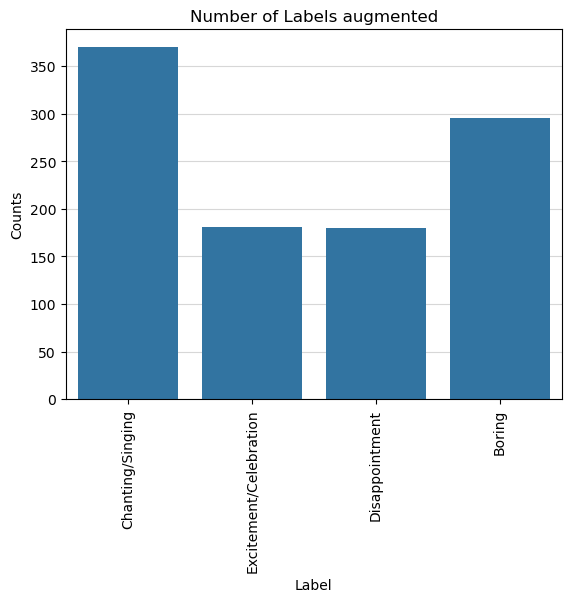

In [49]:
ax = sns.barplot(Counter(hf_dataset['label']))
ax.set(xlabel='Label', ylabel='Counts')
ax.set_xticklabels(meta_labels.keys())
ax.tick_params(axis='x', labelrotation=90)
ax.set_axisbelow(True)
plt.grid(axis = 'y',alpha=0.5)
plt.title('Number of Labels augmented')
plt.show()

Both Barplots show, that the data for "Disappointment" is tripled.

##### Train- and Test-Split

In [55]:
gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=42)
gss.get_n_splits()

for i, (train_index, test_index) in enumerate(gss.split(X=hf_dataset["input_values"], y=hf_dataset["label"], groups=augmented_groups)):
    print(f"Fold {i}:")
    print(f"  Train: source={set(augmented_groups[train_index])}")
    print(f"  Test:  source={set(augmented_groups[test_index])}")

Fold 0:
  Train: source={np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(1), np.int64(5), np.int64(14)}
Fold 1:
  Train: source={np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(2), np.int64(13), np.int64(6)}
Fold 2:
  Train: source={np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(1), np.int64(13), np.int64(5)}
Fold 3:
  Train: source={np.int64(1), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(2), np.

In [56]:
# select one train test split
(train_index, test_index) = next(gss.split(X=hf_dataset["input_values"], y=hf_dataset["label"], groups=augmented_groups))

In [57]:
train_ds = hf_dataset.select(train_index)
train_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 757
})

In [58]:
test_ds = hf_dataset.select(test_index)
test_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 269
})

#### 8.2.2 Model Parameters

In [59]:
model2train = AutoModelForAudioClassification.from_pretrained(
    model_name,
    num_labels = len(meta_labels),
    label2id = meta_labels,
    id2label = {v:k for k,v in meta_labels.items()},
    ignore_mismatched_sizes = True
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
batch_size = 8
args = transformers.TrainingArguments(
    f'{model_name.split("/")[-1]}-ft_stadium',

    learning_rate=1e-5,
    warmup_ratio=0.1,


    eval_strategy = "steps",
    eval_steps = 10,
    logging_steps=10,

    save_strategy = "epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    gradient_accumulation_steps=4,
    num_train_epochs=5,
    load_best_model_at_end=False,
    push_to_hub=False,
)

In [61]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(torch.long)  # Labels in int64 konvertieren
        outputs = model(**inputs)
        logits = outputs.logits.to(torch.float32)  # Logits in float32 konvertieren

        # Loss-function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)

        metrics = {
            'accuracy': skm.accuracy_score(labels, preds),
            'macro_f1': skm.f1_score(labels, preds, average='macro'),
            'weighted_f1': skm.f1_score(labels, preds, average='weighted')
        }

        return metrics

In [62]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(hf_dataset['label']),
    y = hf_dataset['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.6932, 1.4171, 1.4250, 0.8695], device='cuda:0')


In [63]:
trainer = CustomTrainer(
    model=model2train,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    processing_class = feature_extractor, #tokenizer=feature_extractor,
    class_weights=class_weights,
    compute_metrics=CustomTrainer.compute_metrics
)

#### 8.2.3 Training


In [64]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
10,1.294100,1.142054,0.553903,0.526222,0.558564
20,0.708500,0.662477,0.810409,0.797944,0.812200
30,0.384800,0.493248,0.840149,0.829165,0.841076
40,0.220500,0.429587,0.877323,0.866684,0.878539
50,0.207500,0.402436,0.873606,0.867714,0.873432
60,0.106700,0.403008,0.873606,0.876108,0.876171
70,0.092800,0.394921,0.851301,0.840588,0.852034
80,0.044900,0.369280,0.877323,0.878195,0.878189
90,0.057600,0.350573,0.881041,0.875208,0.881564
100,0.031200,0.368348,0.866171,0.864712,0.867473


TrainOutput(global_step=115, training_loss=0.2774338882902394, metrics={'train_runtime': 539.2218, 'train_samples_per_second': 7.019, 'train_steps_per_second': 0.213, 'total_flos': 2.516143914709156e+17, 'train_loss': 0.2774338882902394, 'epoch': 4.968421052631579})

In [65]:
training_logs  = trainer.state.log_history
len(training_logs)

23

In [67]:
loss_values = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]
steps = [log["step"] for log in training_logs if "loss" in log]

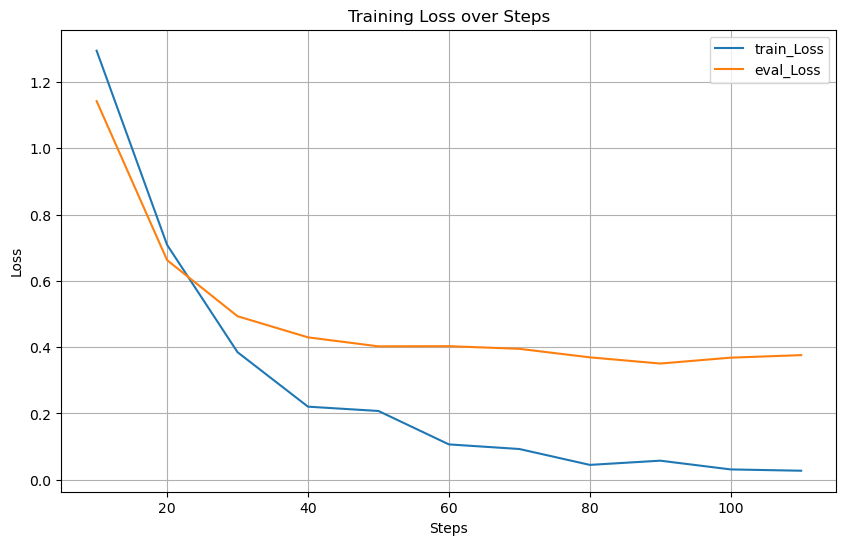

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(steps, loss_values, label="train_Loss")
plt.plot(steps, eval_loss, label="eval_Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.grid()
plt.show()

The graph shows that the model is fully trained from around 80 steps onwards and then starts to “overfit” as the training loss is increasing and the validation loss doesn't change much.

#### 8.2.4 Testing

In [69]:
pred = trainer.predict(test_ds)

In [71]:
print(classification_report(pred.label_ids, pred.predictions.argmax(1)))

              precision    recall  f1-score   support

           0       0.96      0.86      0.91       100
           1       0.86      0.90      0.88        40
           2       0.90      0.78      0.84        60
           3       0.74      0.91      0.82        69

    accuracy                           0.86       269
   macro avg       0.86      0.86      0.86       269
weighted avg       0.87      0.86      0.86       269



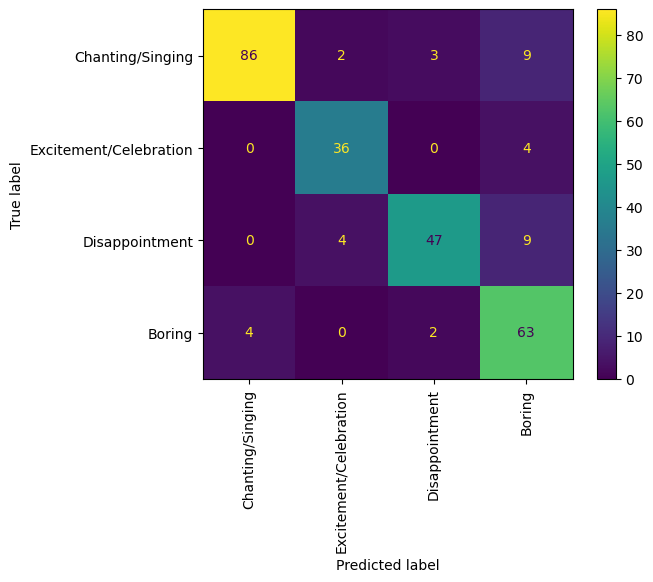

In [70]:
cmd = skm.ConfusionMatrixDisplay(
    skm.confusion_matrix(pred.label_ids, pred.predictions.argmax(1)),
    display_labels = meta_labels.keys()
)
cmd.plot(xticks_rotation="vertical")

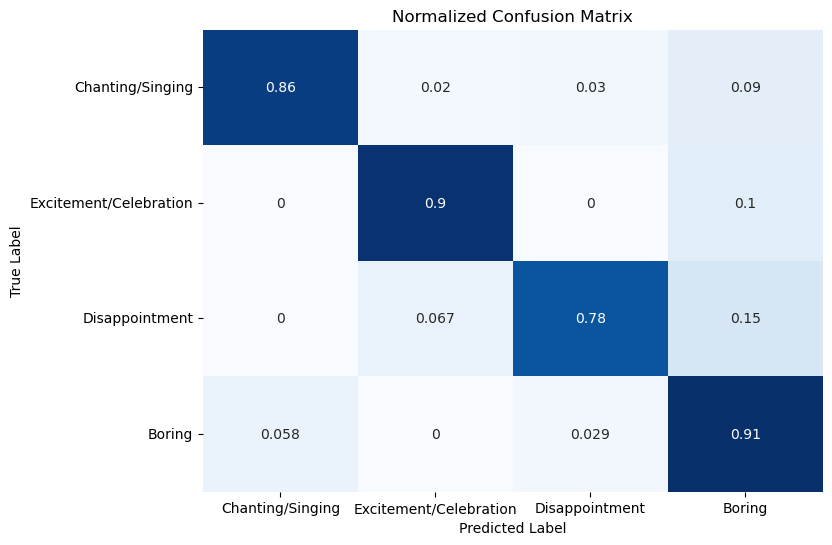

In [75]:
id2label = {v:k for k,v in meta_labels.items()}
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(1), normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

In the normalized confusion matrix it can be seen that the labels are recognized worse (86% accuracy) compared to the previous model (90% accuracy) and roughly equivalent to the model without augmentation (86% accuracy). Overall, except “Boring”, the accuracy of every label drops. With that, additional data augmentation won't be explored, because it may worsen more. Also with more data augmentation, there will be more "same" or closely related data, which can led more to overfitting and resulting in a less accurate model.

## 9. Conclusion

Overall, an increase in accuracy could be achieved by combining labels. Moreover, the usage of data augmentation on the model increases also the accuracy. However, when combining labels, the requirements for the model should always be taken into account, as this reduces the complexity of the output and does may not meet the desired requirements. It must also be taken into account that by augmentation no newly generated data is used. This can lead to an overwriting and over representation of the training data. To increase furthermore the accuracy of the model, a semi-supervised procedure can be promising, because the isn't much data, other options would be to change the model to better needs, but will require a deep understanding of the architecture
